## Policy gradient
### REINFORCE ALGORITHM - MONTE CARLO APPROACH

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

First, let's define our policy network $\pi$:

In [4]:
class PolicyNetwork(nn.Module):
    def __init__(self, n_inputs, n_outputs, hidden_dim_size):
        super(PolicyNetwork, self).__init__()
        # 3 fully connected layers
        self.linear1 = nn.Linear(n_inputs, hidden_dim_size)
        self.linear2 = nn.Linear(hidden_dim_size, n_outputs)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        # instead of returning one output, let's return logπ together with π
        probs = F.softmax(self.linear2(x), dim=-1)
        log_probs = torch.log(probs)

        return probs, log_probs

In [5]:
# defining the model and optimizers instances
model = PolicyNetwork(n_inputs=4, n_outputs=2, hidden_dim_size=128).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=2e-4)

In [6]:
# loading the CartPole environment
# https://gymnasium.farama.org/environments/classic_control/cart_pole/
env = gym.make('CartPole-v1')

Final loop:

- generate a trajectory $\tau$ following policy $\pi(\cdot | \cdot, \theta)$
- for each $t$ in $\tau$:
    - $G_t \leftarrow \sum_{k=t+1}^{T} \gamma^{k-t-1} r_k$
    - $\theta \leftarrow \theta + \alpha \gamma^t G_t \nabla \ln \pi (a_t|s_t, \theta)$

with $G_t$ being the discounted reward in future at timestep $t$, $\theta$ meaning policy network parameters and trajectory $tau$ being the set of states, actions and rewards $(s_0, a_0, r_0, s_1, ..., s_T, a_T, r_T)$

In [7]:
NUM_TRAJECTORIES = 2000
MAX_EPISODE_LENGTH = 500
gamma = 0.9
# placeholders for rewards for each episode
rewards = []
losses = []
# iterating through trajectories
for tau in tqdm(range(NUM_TRAJECTORIES)):
    # resetting the environment
    state, info = env.reset()
    # setting done to False for while loop 
    done = False
    # storing trajectory and logπ(a_t|s_t, θ)
    transition_buffer = []
    log_probs = []
    
    t = 0
    while done == False and t < MAX_EPISODE_LENGTH:
        # retrieving π and logπ
        action_probs, action_log_probs = model(torch.tensor(state).to(device))
        # sampling the action according to the distribution given by π
        action = np.random.choice([0, 1], p=action_probs.flatten().detach().cpu().numpy())
        # keeping track of previous state
        prev_state = state
        # environment step
        state, reward, done, truncation, info = env.step(action)
        # since the Cartpole environment already provides a reward based on the episodes length, and we 
        # get the log_prob right away at every timestep, let's just  
        transition_buffer.append(reward)
        log_probs.append(action_log_probs[action])

        t += 1
    # logging the episode length as a cumulative reward
    rewards.append(t)
    returns = []
    for t_prime in range(t):
        # computing discounted rewards in future for every timestep
        G = 0
        for i, tick in enumerate(transition_buffer[t_prime:]):
            G += (gamma ** i) * tick
        returns.append(G)
    # normalizing the returns
    returns = torch.tensor(returns).to(device)
    returns = (returns - returns.mean()) / (returns.std() + 1e-9)
    # computing the gradients for each timestep
    gradients = []
    for log_prob, Gt in zip(log_probs, returns):
        gradients.append(- Gt * log_prob)
    # updating the policy network
    optimizer.zero_grad()
    # summing all gradients for one batch update instead of update at each timestep
    loss = torch.stack(gradients).sum()
    losses.append(loss.item())
    loss.backward()
    optimizer.step()


100%|██████████| 2000/2000 [05:00<00:00,  6.65it/s]


Text(0.5, 1.0, 'REINFORCE cumulative rewards')

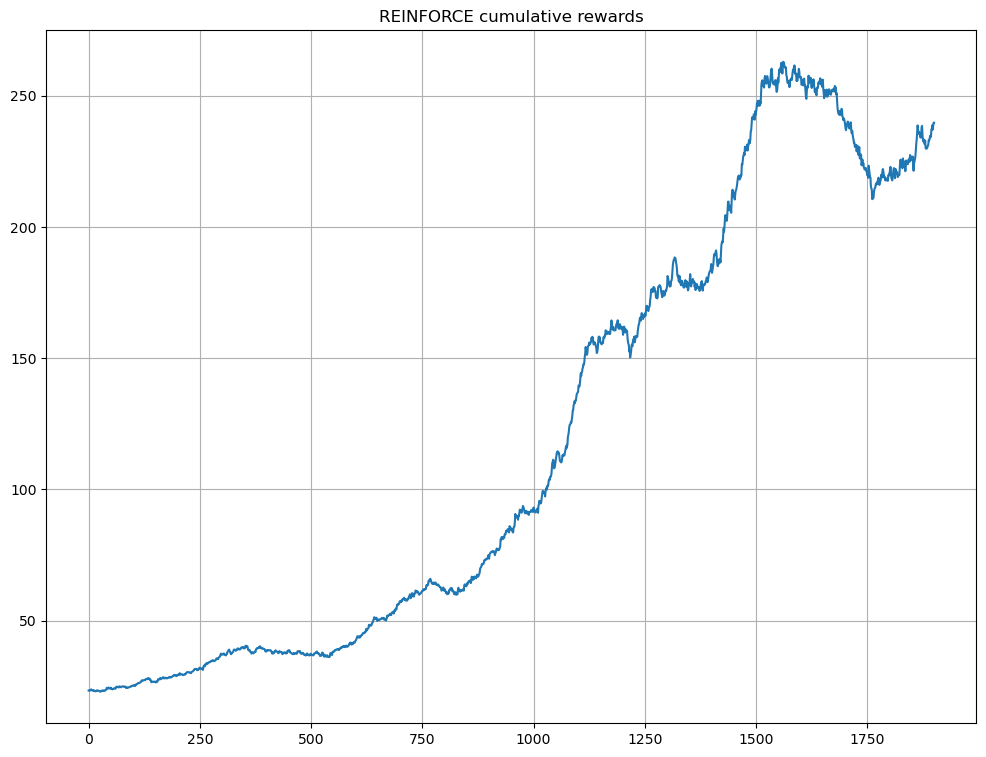

In [8]:
# plot the results of the training
plt.figure(figsize=(12,9))
plt.plot(running_mean(rewards,100))
plt.grid()
plt.title("REINFORCE cumulative rewards")

In [9]:
import pandas as pd

df = pd.DataFrame(rewards, columns=['reward'])
df.to_csv('REINFORCE.csv')

### Not normalizing returns

In [119]:
model_bis = PolicyNetwork(n_inputs=4, n_outputs=2, hidden_dim_size=128).to(device)
optimizer_bis = torch.optim.Adam(params=model_bis.parameters(), lr=2e-4)

In [120]:
NUM_TRAJECTORIES = 2000
MAX_EPISODE_LENGTH = 500
gamma = 0.9
# placeholders for rewards for each episode
rewards_non_norm = []
losses_non_norm = []
# iterating through trajectories
for tau in tqdm(range(NUM_TRAJECTORIES)):
    # resetting the environment
    state, info = env.reset()
    # setting done to False for while loop 
    done = False
    # storing trajectory and logπ(a_t|s_t, θ)
    transition_buffer = []
    log_probs = []
    
    t = 0
    while done == False and t < MAX_EPISODE_LENGTH:
        # retrieving π and logπ
        action_probs, action_log_probs = model_bis(torch.tensor(state).to(device))
        # sampling the action according to the distribution given by π
        action = np.random.choice([0, 1], p=action_probs.flatten().detach().cpu().numpy())
        # keeping track of previous state
        prev_state = state
        # environment step
        state, reward, done, truncation, info = env.step(action)
        # since the Cartpole environment already provides a reward based on the episodes length, and we 
        # get the log_prob right away at every timestep, let's just  
        transition_buffer.append(reward)
        log_probs.append(action_log_probs[action])

        t += 1
    # logging the episode length as a cumulative reward
    rewards_non_norm.append(t)
    returns = []
    for t_prime in range(t):
        # computing discounted rewards in future for every timestep
        G = 0
        for i, tick in enumerate(transition_buffer[t_prime:]):
            G += (gamma ** i) * tick
        returns.append(G)
    # normalizing the returns
    returns = torch.tensor(returns).to(device)
    # computing the gradients for each timestep
    gradients = []
    for log_prob, Gt in zip(log_probs, returns):
        gradients.append(- Gt * log_prob)
    # updating the policy network
    optimizer_bis.zero_grad()
    # summing all gradients for one batch update instead of update at each timestep
    loss = torch.stack(gradients).sum()
    losses_non_norm.append(loss.item())
    loss.backward()
    optimizer_bis.step()


  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [16:51<00:00,  1.98it/s]


Text(0.5, 1.0, 'REINFORCE cumulative rewards')

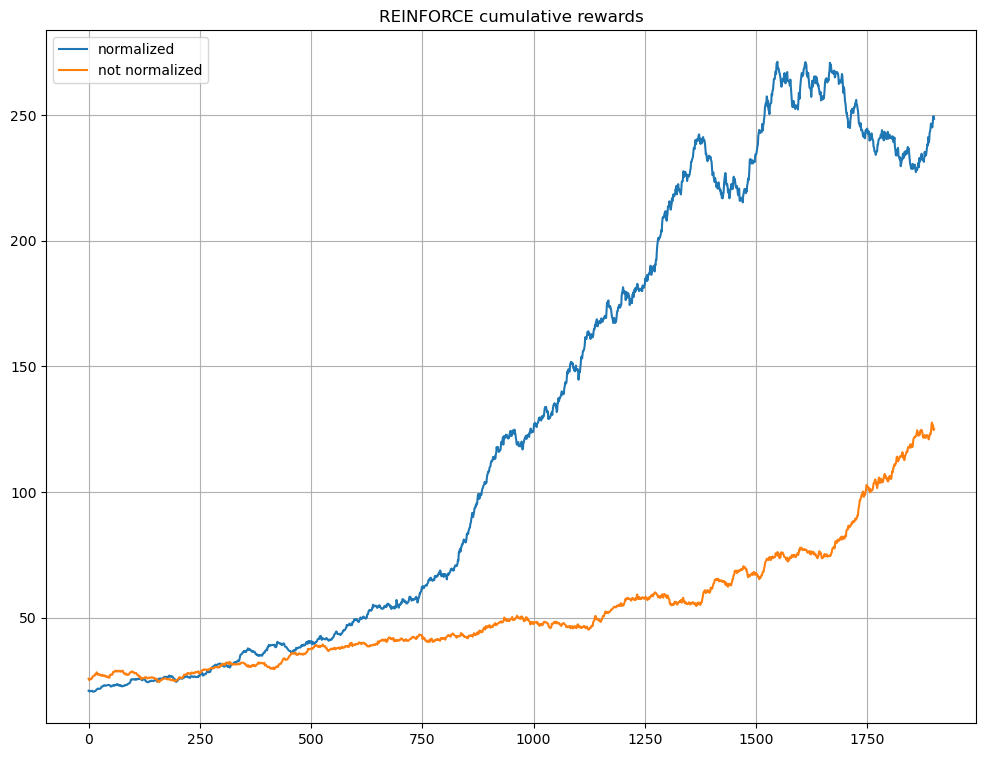

In [121]:
plt.figure(figsize=(12,9))
plt.plot(running_mean(rewards,100), label="normalized")
plt.plot(running_mean(rewards_non_norm, 100), label="not normalized")
plt.grid()
plt.legend()
plt.title("REINFORCE cumulative rewards")

See Chapter 13.3 of Sutton&Barto "Reinforcement Learning"

Additional information about normalizing the discounted rewards:
 - http://karpathy.github.io/2016/05/31/rl/, paragraph *More general advanced functions*